In [1]:
# Pandas to read csv file and other things
import pandas as pd
# Datareader to download price data from Yahoo Finance
import pandas_datareader as web
# Statsmodels to run our multiple regression model
import statsmodels.api as sm
# To download the Fama French data from the web
import urllib.request
# To unzip the ZipFile 
import zipfile
import numpy as np
from scipy.optimize import minimize,root_scalar
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
print(pd.__version__)


1.0.5


In [2]:
def get_fama_french():
    # Web url
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    # Download the file and save it
    
    # We will name it fama_french.zip file
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Next we extact the file data
    zip_file.extractall()
    
    # Make sure you close the file after extraction
    zip_file.close()
    
    # Now open the CSV file
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)

    # We want to find out the row with NULL value
    # We will skip these rows
    # need to convert series to array to call "nonzero" function
    ff_row = np.array(ff_factors.isnull().any(1)).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)
    
    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
    
    # Format dates to end of month
    ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/ 100)
    return ff_factors

In [3]:
ff_data = get_fama_french()
print(ff_data.tail())

            Mkt-RF     SMB     HML      RF
2020-05-31  0.0558  0.0247 -0.0495  0.0001
2020-06-30  0.0246  0.0270 -0.0222  0.0001
2020-07-31  0.0577 -0.0218 -0.0131  0.0001
2020-08-31  0.0763 -0.0026 -0.0295  0.0001
2020-09-30 -0.0363  0.0010 -0.0259  0.0001


In [4]:
# Last day of FF data
ff_last = ff_data.index[ff_data.shape[0] - 1].date()
# Build the get_price function
# We need 3 arguments, ticker, start and end date
def get_price_data(ticker, start, end):
    price = web.get_data_yahoo(ticker, start, end)
    price = price['Adj Close'] # keep only the Adj Price col
    return price

In [5]:
# Get Price data for Fidelity's fund
price_data = get_price_data("FCNTX", "1980-01-01", "2020-09-30")
# Make sure to only have data upto last date of Fama French data
price_data = price_data.loc[:ff_last]
print(price_data.tail())

Date
2020-09-24    16.030001
2020-09-25    16.330000
2020-09-28    16.549999
2020-09-29    16.570000
2020-09-30    16.680000
Name: Adj Close, dtype: float64


In [6]:
def get_return_data(price_data, period = "M"):
    
    # Resample the data to monthly price
    price = price_data.resample(period).last()
    
    # Calculate the percent change
    ret_data = price.pct_change()[1:]
    
    # convert from series to DataFrame
    ret_data = pd.DataFrame(ret_data)
    
    # Rename the Column
    ret_data.columns = ['portfolio']
    return ret_data
    
ret_data = get_return_data(price_data, "M")
print(ret_data.tail())

            portfolio
Date                 
2020-05-31   0.064588
2020-06-30   0.040446
2020-07-31   0.071716
2020-08-31   0.096310
2020-09-30  -0.048488


In [7]:
# Merging the data
all_data = pd.merge(pd.DataFrame(ret_data),ff_data, how = 'inner', left_index= True, right_index= True)
# Rename the columns
all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)
# Calculate the excess returns
all_data['port_excess'] = all_data['portfolio'] - all_data['RF']
print(all_data.tail())

            portfolio  mkt_excess     SMB     HML      RF  port_excess
2020-05-31   0.064588      0.0558  0.0247 -0.0495  0.0001     0.064488
2020-06-30   0.040446      0.0246  0.0270 -0.0222  0.0001     0.040346
2020-07-31   0.071716      0.0577 -0.0218 -0.0131  0.0001     0.071616
2020-08-31   0.096310      0.0763 -0.0026 -0.0295  0.0001     0.096210
2020-09-30  -0.048488     -0.0363  0.0010 -0.0259  0.0001    -0.048588


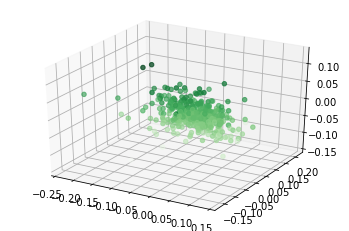

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = all_data.iloc[:,1]
x2 = all_data.iloc[:,2]
x3 = all_data.iloc[:,3]
ax.scatter3D(x1, x2, x3, c=x3, cmap='Greens');

plt.show()

#actual implementation of liner regression
#compute y_pred, compare with y_data above etc etc
#assume more code here

exit() 

In [9]:
model = sm.formula.ols(formula = "port_excess ~ mkt_excess + SMB + HML", data = all_data).fit()
print(model.params)
print(model.summary())
print(model.pvalues[0]) # alpha
print(model.pvalues[1]) # market excess
print(model.pvalues[2]) # SMB
print(model.pvalues[3]) # HML
#model??
#display(help(model))
print(model.tvalues[0]) # alpha
print(model.tvalues[1]) # market excess
print(model.tvalues[2]) # SMB
print(model.tvalues[3]) # HML
print(model.params.Intercept)

Intercept     0.001327
mkt_excess    0.897902
SMB           0.027838
HML          -0.113354
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            port_excess   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     636.7
Date:                Wed, 18 Nov 2020   Prob (F-statistic):          1.50e-167
Time:                        15:12:58   Log-Likelihood:                 1196.6
No. Observations:                 488   AIC:                            -2385.
Df Residuals:                     484   BIC:                            -2368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [10]:
def run_reg_model(ticker,start,end):
    # Get FF data
    ff_data = get_fama_french()
    ff_last = ff_data.index[ff_data.shape[0] - 1].date()
    #Get the fund price data
    price_data = get_price_data(ticker,start,end)
    price_data = price_data.loc[:ff_last]
    ret_data = get_return_data(price_data, "M")
    all_data = pd.merge(pd.DataFrame(ret_data),ff_data, how = 'inner', left_index= True, right_index= True)
    all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)
    all_data['port_excess'] = all_data['portfolio'] - all_data['RF']
    # Run the model
    model = sm.formula.ols(formula = "port_excess ~ mkt_excess + SMB + HML", data = all_data).fit()
    #return model.params
    return model

In [11]:
ggrax_model = run_reg_model("GGRAX", start = "1999-05-01", end = "2019-06-30")
print(ggrax_model)
print(ggrax_model.pvalues[2])

1.472300617687898e-12


In [12]:
%%time
tickers_df = pd.read_csv('companylist.csv')
print(len(tickers_df))
tickers_df = tickers_df.loc[tickers_df['MarketCap'].str.contains(r'B',na=True)]
print(len(tickers_df))
tickers_df = tickers_df.dropna(subset=['Sector','industry','LastSale','IPOyear'],axis=0,how='any')
print(len(tickers_df))
tickers_df = tickers_df.loc[tickers_df['IPOyear']<2007]
print(len(tickers_df))
display(tickers_df.head())
tickers_list = tickers_df.iloc[:,0].tolist()
tickers_list
# tickers_str = " ".join(tickers_list)
# tickers_str

3849
1888
831
234


,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote,Unnamed: 8
7,FLWS,"1-800-FLOWERS.COM, Inc.",21.37,$1.38B,1999.0,Consumer Services,Other Specialty Stores,https://old.nasdaq.com/symbol/flws,NaN
17,JOBS,"51job, Inc.",69.70,$4.68B,2004.0,Technology,Diversified Commercial Services,https://old.nasdaq.com/symbol/jobs,NaN
33,ACAD,ACADIA Pharmaceuticals Inc.,47.35,$7.52B,1985.0,Health Care,Major Pharmaceuticals,https://old.nasdaq.com/symbol/acad,NaN
72,ADBE,Adobe Inc.,461.11,$221.2B,1986.0,Technology,Computer Software: Prepackaged Software,https://old.nasdaq.com/symbol/adbe,NaN
75,AEIS,"Advanced Energy Industries, Inc.",69.02,$2.65B,1995.0,Capital Goods,Industrial Machinery/Components,https://old.nasdaq.com/symbol/aeis,NaN


Wall time: 41.8 ms


['FLWS',
 'JOBS',
 'ACAD',
 'ADBE',
 'AEIS',
 'AKAM',
 'ALXN',
 'ALGN',
 'ALKS',
 'ALGT',
 'ALNY',
 'GOOG',
 'AIMC',
 'AMZN',
 'AMWD',
 'ABCB',
 'AMSF',
 'AMGN',
 'AMKR',
 'ANSS',
 'AAPL',
 'AMAT',
 'ARNA',
 'ASML',
 'AZPN',
 'ASTE',
 'ATRC',
 'BIDU',
 'BANF',
 'BECN',
 'BBBY',
 'BMRN',
 'BLKB',
 'EPAY',
 'BRKS',
 'BLDR',
 'CHRW',
 'CALM',
 'CSIQ',
 'CSII',
 'CWST',
 'CASY',
 'CENT',
 'CERN',
 'GTLS',
 'CHKP',
 'CTAS',
 'CRUS',
 'CSCO',
 'CTXS',
 'CCMP',
 'CME',
 'COKE',
 'CGNX',
 'CTSH',
 'COLB',
 'COLM',
 'CVLT',
 'CGEN',
 'CNMD',
 'CPRT',
 'CORT',
 'CSGP',
 'CBRL',
 'CACC',
 'CREE',
 'CROX',
 'CSGS',
 'CYTK',
 'XRAY',
 'DXCM',
 'DISH',
 'DLTR',
 'EBAY',
 'EHTH',
 'ENTG',
 'EQIX',
 'EEFT',
 'EXAS',
 'EXEL',
 'EXLS',
 'FFIV',
 'FARO',
 'FAST',
 'FSLR',
 'FCFS',
 'FISV',
 'FLEX',
 'FLIR',
 'FORM',
 'GRMN',
 'ROCK',
 'GILD',
 'OMAB',
 'HCSG',
 'HTLD',
 'HSIC',
 'HSKA',
 'HMSY',
 'HOLX',
 'HOMB',
 'HUBG',
 'ICFI',
 'ICLR',
 'ICUI',
 'IDXX',
 'INFO',
 'IIVI',
 'ILMN',
 'IMGN',
 'NSIT',
 '

In [13]:
%%time
a=0
b=0
ticker=[]
for i in tickers_list[:]:
    try:
        ggrax_model = run_reg_model(i, start = "1999-05-01", end = "2019-06-30")
        a+=1
        if ggrax_model.pvalues[0]<0.05 and ggrax_model.pvalues[2]<0.05 and ggrax_model.pvalues[3]<0.05 and ggrax_model.params.Intercept>0:
            b+=1
            ticker.append(i)
        print(234-a) #234 after filtering nasdaq stocks
    except Exception as e:
        print(str(e))
        pass
print(str(b/a)+'%')
ticker #statistically significant p value

233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
0.04700854700854701%
Wall time: 14min 40s


['ALXN',
 'CHKP',
 'GILD',
 'HCSG',
 'HOMB',
 'ILMN',
 'MNRO',
 'NBIX',
 'NVDA',
 'ODFL',
 'POOL']

In [14]:
for i in ['ALXN','CHKP','GILD','HCSG','HOMB','ILMN','MNRO','NBIX','NVDA','ODFL','POOL']:
    ggrax_model = run_reg_model(i, start = "1999-05-01", end = "2019-06-30")
    print(ggrax_model.params.Intercept)

#  find highest 3 R^2 stocks since we only have 3 unknowns:
# .335 ALXN -65.87% alpha=0.019566
# .361 CHKP 111.3% alpha=0.01333
# .174
# .121
# .378 HOMB 54.57% alpha=0.01
# .271
# .151
# .260
# .314
# .155
# .319
          
ticker = ['ALXN','CHKP','HOMB']

0.019564266466639814
0.013336366276620437
0.01595993235517934
0.011226784488733519
0.010006630750737407
0.020318938219351008
0.0133587832870867
0.022563840944168086
0.023828074552818386
0.016747473392872927
0.012958578778308109


In [15]:
%%time
beta=np.array([])
smb=np.array([])
hml=np.array([])
for i in ticker[:3]:
    beta = np.append(beta,[run_reg_model(i, start = "1999-05-01", end = "2019-06-30").params.mkt_excess])
    smb = np.append(smb,[run_reg_model(i, start = "1999-05-01", end = "2019-06-30").params.SMB])
    hml = np.append(hml,[run_reg_model(i, start = "1999-05-01", end = "2019-06-30").params.HML])
# display(beta)
# display(smb)
# display(hml)
matrix = np.vstack([beta,smb,hml])
print(matrix) #number of asset by 3 independent variables
#z = np.zeros([3,3])
z = np.array([[-1]*3,[0]*3,[0]*3])
print(z)

#matrix = np.append(matrix,z,axis=1) #add column of zeros to form square matrix
#matrix = np.linalg.solve(matrix,z) # only for square matrix
np.linalg.inv(matrix).dot(z) # only for square matrix
#https://scipy.github.io/devdocs/tutorial/linalg.html

#x, residuals, rank, s = np.linalg.lstsq(matrix,z) #Least squares is a standard approach to problems with more equations than unknowns, also known as overdetermined systems.
#x, residuals, rank, singular version of matrix(also absolute of eigenvalue)
#https://sodocumentation.net/numpy/topic/3753/linear-algebra-with-np-linalg
print(x)


[[ 0.92758213  1.07307085  0.56230307]
 [ 1.61951529  0.60609821  0.72037254]
 [-1.50440748 -1.35598889  0.94509794]]
[[-1 -1 -1]
 [ 0  0  0]
 [ 0  0  0]]


NameError: name 'x' is not defined

In [16]:
# # optimization module
# def objective(x): # x are the p-value significant nasdaq stocks
#     x1=x[0]
#     x2=x[1]
#     x3=x[2]
#     x4=x[3]
#     return -1.50440748*x1-1.35598889*x2-0.50999618*x3+0.77768992*x4
# def constraint1(x):
#     return -x[0]-x[1]-x[2]-x[3]
# initializer = np.ones([4,1])
# #print(objective(initializer))
# bounds = tuple((-1,1) for i in range(0,4))
# con1 = {'type':'eq','fun':constraint1}
# cons = [con1]
# #print(initializer)
# #print(bounds)

# sol = minimize(objective,initializer,method='SLSQP',bounds=bounds,constraints=[])
# display(sol)